# Exponential Integrate-and-fire model

## Model Introduction

Exponential Integrate-and-fire model(ExpIF model) is a neuron model derive from LIF model. As presented before, LIF model is a simple model include only a differential equation and a threshold mechanism, which hardly captures any minor property. ExpIF model therefore is proposed by Fourcaud-Trocmé(2003) to approximate conductance-based models such as Wang-Buzsáki model(Wang and Buzsáki, 1996).

The differential equation of all integrate-and-fire models can be write as:

$$C_m\frac{dV}{dt} = -\frac{V-V_{rest}}{R_m} + \psi(V) + I(t)$$

In which $V$ is membrane potential, $V_{rest}$ is resting potential, $R_m$ is membrane resistance, $C_m$ is membrane capacitance, and $I(t)$ is time-dependent input current, composed of external input current and postsynaptic current.

When $V>=V_{th}$, the membrane potential will be reset to $V_{reset}$.

In LIF model, $\psi(V) = 0$ is a special condition. As for ExpIF model, we propose another threshold $V_T$:

$$\psi^{'}(V_T) = g_m = \frac{1}{R_m}$$

$V_T$ is the maximum membrane potential at which neuron can stay steady with a constant input but not fire. The corresponding threshold input $I(t) = \frac{V_T-V_{rest}}{R_m} - \psi(V_T)$ is the maximum value of constant external input, with which neuron can meet $V_T$ without fire.

Another parameter $\varDelta_T$ refers to a spike slope factor, measures the sharpness of spike initation. $\varDelta_T$ is defined as:

$$\varDelta_T = \frac{g_m}{\psi^{''}(V_T)}$$

Therefore ExpIF model is given by:

$$\psi(V) = g_m\varDelta_Te^{\frac{V-Vrest}{\varDelta_T}}$$

combine it with the general equation we get:

$$C_m\frac{dV}{dt} = -\frac{V-V_{rest}}{R_m} + g_m\varDelta_Te^{\frac{V-Vrest}{\varDelta_T}} + I(t)$$

## Model Implementation

In [1]:
import numpy as np
import brainpy as bp
import matplotlib.pyplot as plt
import math

In [2]:
## define Exponential Integrate-and-Fire model
def ExpIF_model(Vrest = -65., Vreset = -68. , Vsp = 20, Vth = -30., VT = -59.9, delta_T = 3.48, 
                  Rm = 10., Cm = 1., tau_m = 10., refTime = 1.7, noise = 0.):
    ST = bp.types.NeuState(
        {'Vm': -65., 'refState': 0, 'input': 0, 'isFire': 0, 'spikeCnt':0}
    )
    '''
    ExpIF neuron model.
    Vm: membrane potential.
    refState: refractory state.
    input: external input, from stimulus and other synapses.
    isFire: if neuron generates a spike at this moment, then flag isFire = 1, otherwise isFire = 0.
    spikeCnt: total spike cnt (record to compute firing rate).
    '''
    
    @bp.integrate
    def int_v(V, _t_, I_syn):  # integrate u(t)
        return (- ( V - Vrest ) + delta_T * exp((V - VT)/delta_T) + Rm * I_syn) / tau_m, noise / tau_m

    def update(ST, _t_):  
        # update variables
        refPeriod = refTime // dt  #refractory
        if ST['refState'] <= 0:
            V = int_v(ST['Vm'], _t_, ST['input'])
            if V >= Vth:
                V = Vsp
                ST['refState'] = refPeriod
                ST['spikeCnt'] += 1
                ST['isFire'] = 1
            ST['Vm'] = V
        else:
            if ST['isFire']:
                ST['isFire'] = 0
                V = Vreset
                ST['Vm'] = V
            ST['refState'] -= 1
        ST['input'] = 0.  #ST['input'] is current input (only valid for current step, need reset each step)
    
    return bp.NeuType(name = 'Exp_LIF_neuron', requires = dict(ST=ST), steps = update, vector_based = False)

In [4]:
if __name__ == '__main__':
    print("version：", bp.__version__)
    ## set global params
    dt = 0.125        # update variables per <dt> ms
    duration = 350.   # simulate duration
    bp.profile.set(backend = "numba", dt = dt, merge_steps = True, show_code = False)

version： 0.2.0


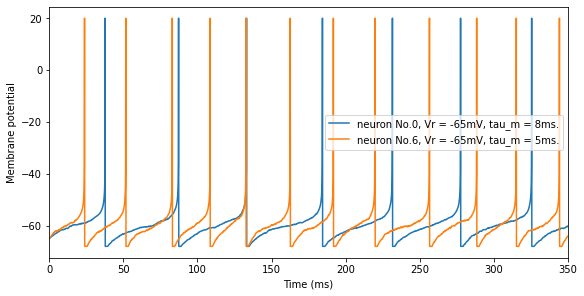

In [6]:
    #ExpIF model
    ExpIF_neuron = ExpIF_model(noise = 0.)
    neu = bp.NeuGroup(ExpIF_neuron, geometry = (10, ), monitors = ['Vm', 'isFire'],
                      pars_update = {
                     'Vrest': np.random.randint(-65, -63, size = (10,)),
                     'tau_m': np.random.randint(5, 10, size = (10,)),
                     'noise': 1.
                     })  #create a neuron group with 10 neurons.
    net = bp.Network(neu)
    
    current, pos_dur = bp.inputs.constant_current([(0.30, duration)])
    
    net.run(duration = pos_dur, inputs = [neu, "ST.input", current], report = False)  
    #simulate for <duration> ms. Give external input = [receiver, field name, strength]

    #paint
    ts = net.ts
    fig, gs = bp.visualize.get_figure(1, 1, 4, 8)
    fig.add_subplot(gs[0, 0])
    plt.plot(ts, neu.mon.Vm[:, 0], label = f'neuron No.{0}, Vr = {neu.pars.get("Vrest")[0]}mV, tau_m = {neu.pars.get("tau_m")[0]}ms.')
    plt.plot(ts, neu.mon.Vm[:, 6], label = f'neuron No.{6}, Vr = {neu.pars.get("Vrest")[6]}mV, tau_m = {neu.pars.get("tau_m")[6]}ms.')
    plt.ylabel('Membrane potential')
    plt.xlim(-0.1, net.t_end - net.t_start + 0.1)
    plt.legend()
    plt.xlabel('Time (ms)')
    plt.show()

<img src="../../images/ExpIF-1.png">

<center>An ExpIF neuron with noisy input | BrainPy-Models</center>

## Model Analysis

### fitting WB model

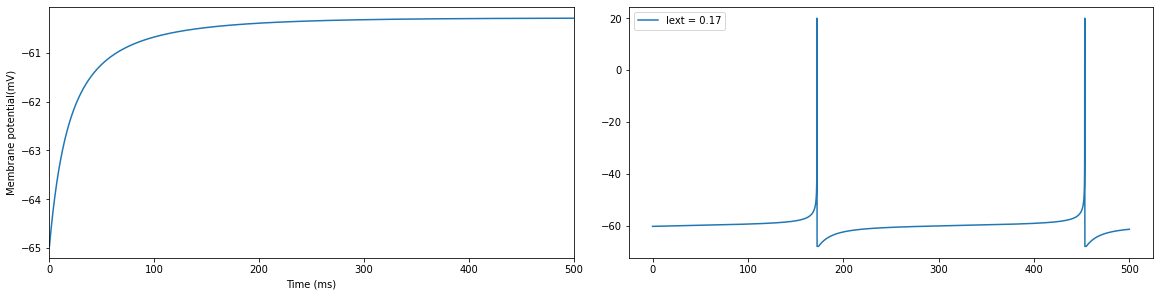

In [7]:
    duration = 500
    ExpIF_neuron = ExpIF_model()
    neu = bp.NeuGroup(ExpIF_neuron, geometry = (1, ), monitors = ['Vm'],
                      pars_update = {
                     'Vrest': -65.,
                     'tau_m': 10,
                     'noise': 0.
                     })  #create a neuron group with 10 neurons.
    net = bp.Network(neu)
    
    #input current = 0.16, under the threshold
    current, pos_dur = bp.inputs.constant_current([(0.16, duration)])
    net.run(duration = pos_dur, inputs = [neu, "ST.input", current], report = False)
    ts = net.ts
    fig, gs = bp.visualize.get_figure(1, 2, 4, 8)
    fig.add_subplot(gs[0, 0])
    plt.plot(ts, neu.mon.Vm[:, 0], label = 'Iext = 0.16')
    plt.ylabel('Membrane potential(mV)')
    plt.xlabel('Time (ms)')
    plt.xlim(-0.1, net.t_end - net.t_start + 0.1)
    
    #input current = 0.17, above the threshold
    current, pos_dur = bp.inputs.constant_current([(0.17, duration)])
    net.run(duration = pos_dur, inputs = [neu, "ST.input", current], report = False)
    fig.add_subplot(gs[0, 1])
    plt.plot(ts, neu.mon.Vm[:, 0], label = 'Iext = 0.17')
    plt.legend()
    plt.show()

Fourcaud-Trocmé (2003) proposed that ExpIF model can easily reproduce the behavior of conductance-based model. For example, Wang-Buzsáki model's $I_T = 0.16\mu A/cm^2$. We can tune the parameters of ExpIF model, so that it can have the same input threshold, as presented above.

With the same proper parameters, ExpIF model can match the f-I curve of WB model. Here we paint two figures to show how well can integrate-and-fire model fit WB model: (TODO: Supplement Needed Here! After WB is realized, add WB curve to this figure, otherwise can only paint ExpIF model)

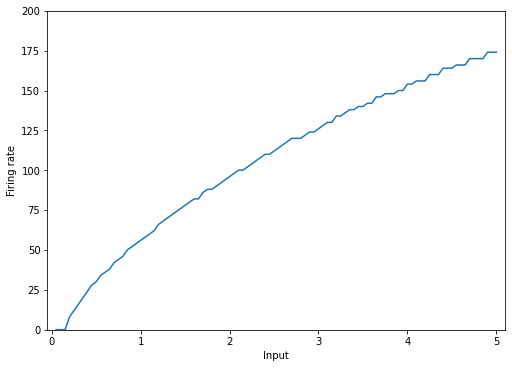

In [8]:
    #fitting WB model curve
    Iext_list = []
    fRate_list = []
    stim_start = 0
    stim_end = 100
    stim_range = stim_end - stim_start
    stim_step = 1
    epoch = stim_range / stim_step
    step = 0
    Iext = 0
    
    for i in range(stim_start, stim_end):
        # buile network
        ExpIF_neuron = ExpIF_model()
        neu = bp.NeuGroup(ExpIF_neuron, geometry = (10, ), monitors = ['Vm', 'spikeCnt'],
                          pars_update = {
                         'Vrest': -65.,
                         'tau_m': 10,
                         'noise': 0.
                         })  #create a neuron group with 10 neurons.
        net = bp.Network(neu)
        #set input
        Iext += 0.05  ##actual stim is range(0, 5, 0.05)
        current, pos_dur = bp.inputs.constant_current([(Iext, duration)])
    
        #simulate
        net.run(duration = pos_dur, inputs = [neu, "ST.input", current])
        
        fRate = neu.mon.spikeCnt[-1, 0] * 1000/duration
        Iext_list.append(Iext)
        fRate_list.append(fRate)
        
        step += 1
        print(f"epoch {step}/{int(epoch)}, input amplitude = {Iext}, firing rate = {fRate}", end = '\r', flush = True)

    #paint
    fig, gs = bp.visualize.get_figure(1, 1, 5, 7)
    fig.add_subplot(gs[0, 0])
    plt.plot(Iext_list, fRate_list)
    plt.xlabel('Input')
    plt.ylabel('Firing rate')
    plt.xlim(Iext_list[0]-0.1, Iext_list[-1]+0.1)
    plt.ylim(-0.1, 200)
    plt.show()

<img src="../../images/ExpIF-2.png">

<center>f-I curve of integrate models and WB model | [1]</center>

Clearly, our ExpIF model match with WB model's f-I curve. (TODO: Supplement Needed Here! After WB, LIF, QIF is realized, add analysis here.)

We should mention that WB model is a type I neuron, which means its firing rate at threshold is 0. Type II neurons are at odds with WB model, whose firing rate is not 0 at threshold.

### receiving sinusoidal input

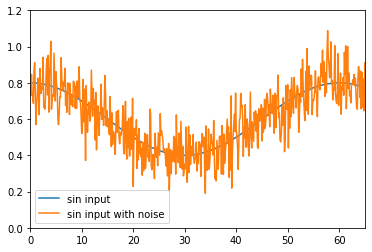

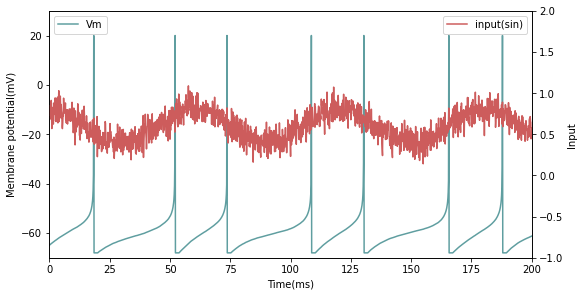

In [10]:
    ## create sin input
    duration = 1000
    epoch = int(np.ceil(duration/dt))
    t = 0
    t_list = []
    Iext_list = []
    for i in range(epoch):
        t += dt
        Iext = 0.60 + 0.20*math.sin(2*math.pi*t/60+math.pi/2)
        t_list.append(t)
        Iext_list.append(Iext)
    
    #add noise 
    mean, var = 0, 0.10
    noise_list = np.random.normal(mean, var, epoch)
    
    
    ExpIF_neuron = ExpIF_model()
    neu = bp.NeuGroup(ExpIF_neuron, geometry = (1, ), monitors = ['Vm', 'input'],
                      pars_update = {
                     'Vrest': -65.,
                     'tau_m': 10,
                     'noise': 0.
                     })  #create a neuron group with 10 neurons.
    net = bp.Network(neu)
    current = np.zeros(int(np.ceil(duration/dt)))
    for i in range(len(current)):
        current[i] = Iext_list[i] + noise_list[i]
    
    
    plt.plot(t_list, Iext_list, label = "sin input")
    plt.plot(t_list, current, label = "sin input with noise")
    plt.xlim(0, 65)
    plt.ylim(0.0, 1.2)
    plt.legend()
    plt.show()
        
    net.run(duration = duration, inputs = [neu, "ST.input", current], report = False)  
    #simulate for <duration> ms. Give external input = [receiver, field name, strength]

    #paint
    ts = net.ts
    fig, gs = bp.visualize.get_figure(1, 1, 4, 8)
    ax = fig.add_subplot(gs[0, 0])
    ax.plot(ts, neu.mon.Vm[:, 0], color = 'cadetblue', label = 'Vm')
    ax.set_xlabel('Time(ms)') 
    ax.set_ylabel('Membrane potential(mV)')
    #ax.set_xlim(-0.1, net.t_end - net.t_start + 0.1)
    ax.set_xlim(-0.1, 200 + 0.1)
    ax.set_ylim(-70, 30)
    ax.legend(loc = 2)
    ax2 = ax.twinx()
    ax2.plot(ts, current, color = 'indianred', label = 'input(sin)')
    ax2.set_ylabel('Input')
    ax2.set_ylim(-1, 2)
    ax2.legend(loc = 1)
    plt.show()

## References

[1] Fourcaud-Trocmé, Nicolas, et al. "How spike generation mechanisms determine the neuronal response to fluctuating inputs." Journal of Neuroscience 23.37 (2003): 11628-11640.

[2] Wang, Xiao Jing . "Gamma Oscillation by Synaptic Inhibition in a Hippocampal Interneuronal Network Model." Journal of Neuroence 16.20(1996):6402-6413.